In [1]:
def nums_visualisation(df,annotation=False):
    '''
    визуализация распределений количественных признаков: 
        - гисторгамма распределения 
        - boxplot распределения
    '''
    columns = df.columns
    cols_num = df.shape[1]

    fstr = '\033[1m{}\033[0m, '* (len(columns)-1) + '\033[1m{}\033[0m'
    if annotation: 
        print(('Всего признаков этого типа {}.\nК ним относятся: ' + fstr).
              format(len(columns),*columns))
    
    indent = 0.05
    fig = plt.figure(figsize=(14,3))
    for i,col in enumerate(columns):
        row = df[col]
        min_diff = pd.Series(row.unique()).sort_values().diff().min()
        bins = min(int((row.max()-row.min()) /min_diff + 1),100)
        
        fig.add_axes([1/cols_num*i, 0.35, 1/cols_num-indent, 1])
        plt.title(col)
        row.plot.hist(bins=bins,density=True)
    
        fig.add_axes([1/cols_num*i, 0, 1/cols_num-indent, 0.2])
        sns.boxplot(x=row)

    plt.tight_layout()
    
def num_visualisation(column,df, left_sloping=False):
    '''
    Визулизация распределения количественного ризнака:
        - гистограмма распределения в валидационной и в полной обучающей выборке 
        - boxplot распределения в валидационной и в полной обучающей выборке
        - гистограмма распределения  в валидационной выборке и в обучающей выборке на марках, 
        встречающихся в валидационной выборке
        - boxplot рапсределения в валидационной выборке и в обучающей выборке на марках, 
        встречающихся в валидационной выборке
    '''
    trn = df[df['sample']==1].dropna(subset=[column,'price'])
    tst = df[df['sample']==0].dropna(subset=[column])
    tst_brands = tst.brand.unique()
    brand_mask = [x in tst_brands for x in trn.brand]
    trn_ = trn[brand_mask]
    
    row_trn = trn[column] 
    row_tst = tst[column] 
    row_trn_ = trn_[column]     

    if left_sloping: 
        max_val = max(row_trn.max(),row_tst.max(),row_trn_.max())
        row_trn = np.log(max_val + 1 - row_trn)
        row_tst = np.log(max_val + 1 - row_tst)
        row_trn_ = np.log(max_val + 1 - row_trn_)        
    else:
        row_trn = np.log(row_trn+1)
        row_tst = np.log(row_tst+1)
        row_trn_ = np.log(row_trn_+1)
    
    fig = plt.figure(figsize=(14,3.5))
    
    nbins = 50
    rows_max = max(row_trn.max(),row_tst.max())
    rows_min = min(row_trn.min(),row_tst.min())    
    step = (rows_max-rows_min)/nbins
    bins = list(np.arange(rows_min,rows_max,step))
#*****************************ax1***********************************
    ax1 = fig.add_axes([0, 0.5, 0.65, 1])
    plt.title('Распределение '+column+' в train\n (на всех марках) и в test' )
    row_trn.plot.hist(bins=bins,density=True,alpha = 0.7,histtype='step',linewidth=5)
    row_trn_.plot.hist(bins=bins,density=True,alpha = 0.7,histtype='step',linewidth=5)    
    row_tst.plot.hist(bins=bins,density=True,alpha = 0.7,histtype='step',linewidth=5)
    plt.legend(['full train','train with brand from test','test']) 
#*****************************ax2***********************************
    ax2 = fig.add_axes([0, 0, 0.65, 0.40]) 
    sns.boxplot(data = [row_trn,row_trn_,row_tst],orient='h',saturation = 0.5)
#*****************************ax3***********************************    
    ax3 = fig.add_axes([0.7, 0, 0.30, 1.5])
    plt.title('Зависимость цены\n от '+column+' в logscale')
    x = rankdata(row_trn)
    y = rankdata(trn.price)
    ax3.set(xlim=(x.min(), x.max()), ylim=(y.min(), y.max()))
    sns.kdeplot(x, y,
                   shade=True, shade_lowest=False)
    plt.show()      
    
def features_price_scatterplot(column):
    fig, ax = plt.subplots(1,len(most_popular_brands), figsize=(16, 6))
    for i,brand in enumerate(most_popular_brands):
        tmp = data[data.brand==brand]
        ax[i].scatter(x = tmp[column], y = tmp.offerprice, alpha=0.3)
        ax[i].set_title('для автмобилей марки ' + brand)
        ax[i].set_xlabel(column)
        ax[i].set_ylabel("offerprice")
        ax[i].set_yscale( "log")
    plt.show()

def features_price_scatterplot(df,stud_column,top_column, n_top):
    top = df[top_column].value_counts().index[:n_top]    
    fig, ax = plt.subplots(1,len(top), figsize=(20, 4))
    
def features_price_scatterplot(df,stud_column,top_column, n_top):
    top = df[top_column].value_counts().index[:n_top]    
    fig, ax = plt.subplots(1,len(top), figsize=(20, 4))

    for i,cat_val in enumerate(top):
        tmp = df[df[top_column]==cat_val]
        x = tmp[stud_column]
        y = tmp.price
        ax[i].scatter(x = x, y = y, alpha=0.3)
        ax[i].set_title('для '+ top_column + ' ' + str(cat_val))
        ax[i].set_xlabel(stud_column)
        ax[i].set_ylabel("price")
#         ax[i].set_yscale( "log")
        xmarg = 0.1*(x.max() - max(x.min(),0))
        ax[i].set_xlim(left=max(x.min(),0)-xmarg,right = x.max()+xmarg)
#         ax[i].set_xmargin(0.2)
    plt.show(x.max())    

## Импорт бибилиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from datetime import datetime
from datetime import date
from sklearn.feature_selection import f_regression, mutual_info_regression
from functools import reduce
from scipy.stats import spearmanr,rankdata

import warnings

# %pylab 
%matplotlib inline

from project_7_functions import *

## Установка параметров и определение констант

In [3]:
from project_7_constants import *

warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 70)    # выведем больше строк
pd.set_option('display.max_columns', 30) # выведем больше колонок

##  Загрузка даных

In [4]:
df_kaggle = pd.read_csv(f'{path}auto_ru_2020_09_09.csv',low_memory=False)
df_kaggle_full = pd.read_csv(f'{path}all_auto_ru_09_09_2020.csv',low_memory=False)

test = pd.read_csv(f'{path}test.csv',low_memory=False)

In [5]:
# test.columns

## Приведение к единому виду

In [6]:
%%time 
externdata_test = externdata_test_unification(test)
# externdata_train = externdata_train_unification(df_kaggle)
externdata_train_full = externdata_train_unification(df_kaggle_full)

Wall time: 5min 29s


## Объединение test и train

In [7]:
# externdata_train['sample'] = 1  # помечаем где у нас трейн
externdata_train_full['sample'] = 1  # помечаем где у нас трейн
externdata_test['sample'] = 0   # помечаем где у нас тест
externdata_test['price'] = np.NaN  # в тесте нет значения price -  пока просто заполняем np.NaN
# объединяем
# externdata = externdata_test.append(externdata_train, sort=False).reset_index(drop=True) 
externdata_full = externdata_test.append(externdata_train_full, sort=False).reset_index(drop=True) 

## EDA
Разделим признаки на количественные `num_cols` , категориальные `cat_cols` и бинарные `bin_cols`.   
К бинарным, очевидно, отнесем признаки с двумя уникальными значениями.  
Категориальными признаками будем считать признаки с количеством уникальных значений от 3 до 27 а также очевидно категориальные название модели и марку автомобиля.   
Порогом для количественного признака будет наличие более чем 27 уникальных значений. При этом учитываем, что название модели и марку автомобиля из количественных признаков мы исключили.  


In [8]:
# Посмотри обьекты какого типа находятся теперь в колонках датасета.
externdata_full.apply(lambda x: type(x.iloc[0]))

bodyType                         <class 'str'>
brand                            <class 'str'>
color                            <class 'str'>
engineDisplacement     <class 'numpy.float64'>
enginePower              <class 'numpy.int64'>
equipment_dict                  <class 'list'>
fuelType                         <class 'str'>
mileage                  <class 'numpy.int64'>
modelDate                <class 'numpy.int64'>
model_name                       <class 'str'>
numberOfDoors            <class 'numpy.int64'>
productionDate           <class 'numpy.int64'>
vehicleTransmission              <class 'str'>
vendor                           <class 'str'>
Владельцы              <class 'numpy.float64'>
Владение                 <class 'numpy.int64'>
ПТС                              <class 'str'>
Привод                           <class 'str'>
Руль                             <class 'str'>
sample                   <class 'numpy.int64'>
price                  <class 'numpy.float64'>
dtype: object

Всё прилично, кроме `equipment_dict`, котрый содержит list опций. На этом этапе приведем этот признак к количеству опций. 

In [9]:
externdata_full.equipment_dict = externdata_full.equipment_dict.apply(len)

Определяем кличество уникальных знчений в каждой колонке и относим признак к соответсвующему типу данных (преобразвание `astype(str)` необходимо для избежания `TypeError: ("unhashable type: 'list'", 'occurred at index equipment_dict')`)

In [10]:
num_uniq = externdata_full.astype(str).nunique()

In [11]:
bin_cols = externdata_full.columns[num_uniq==2].drop('sample')
cat_cols = externdata_full.columns[(num_uniq>2) & (num_uniq<28)].append(pd.Index(['model_name','brand'])) 
num_cols = externdata_full.columns[num_uniq>=28].drop(['model_name','brand','price'])

## Целевая переменная

<AxesSubplot:ylabel='Frequency'>

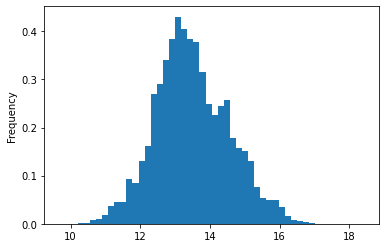

In [12]:
nbins = 50
np.log(externdata_full.price+1).plot.hist(bins=nbins,density=True)

In [13]:
externdata_full.price = np.log(externdata_full.price+1)

Рассмотрим признаки по типам
### Количественные
Ознакомимся с распределением всех признаков (гистограмма и boxplot на всем dataset)

Всего признаков этого типа 7.
К ним относятся: engineDisplacement, enginePower, equipment_dict, mileage, modelDate, productionDate, Владение


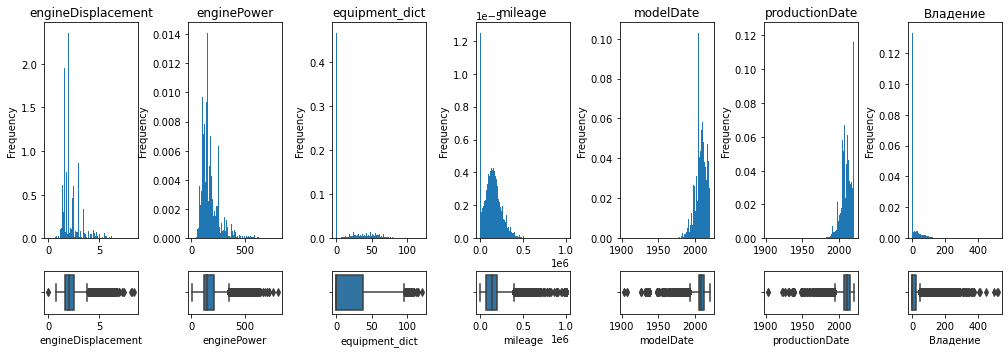

In [14]:
nums_visualisation(externdata_full[num_cols],annotation=True)

Как видим все количественные признаки имеют скошенное распределение:
- **engineDisplacement**, **enginePower**, **equipment_dict**,**mileage** и **Владение** скошены вправо;
- **modelDate**, **productionDate** скошены влево.   
    
Если бы мы испопльзовали модели, чувствтельные к ненормальности распределения признаков, следовало провести преобразование, например логарфимрование и наверное стандартизацию. Но я собираюсь использовать модели, строящий градиентный бустинг над деревьями. Этот класс алгоритвмов нечувствителен к ненормальнотис, поэтому преобразование проводит не имеет смысла. Ну мы и не будем.
    
Попробуем выявить заисимости между числовыми признаками, для этого постоим pairplot и посчитаем матрицу корреляций Спирмена (диаганальные 1-цы уберем, чтобы не мешали).

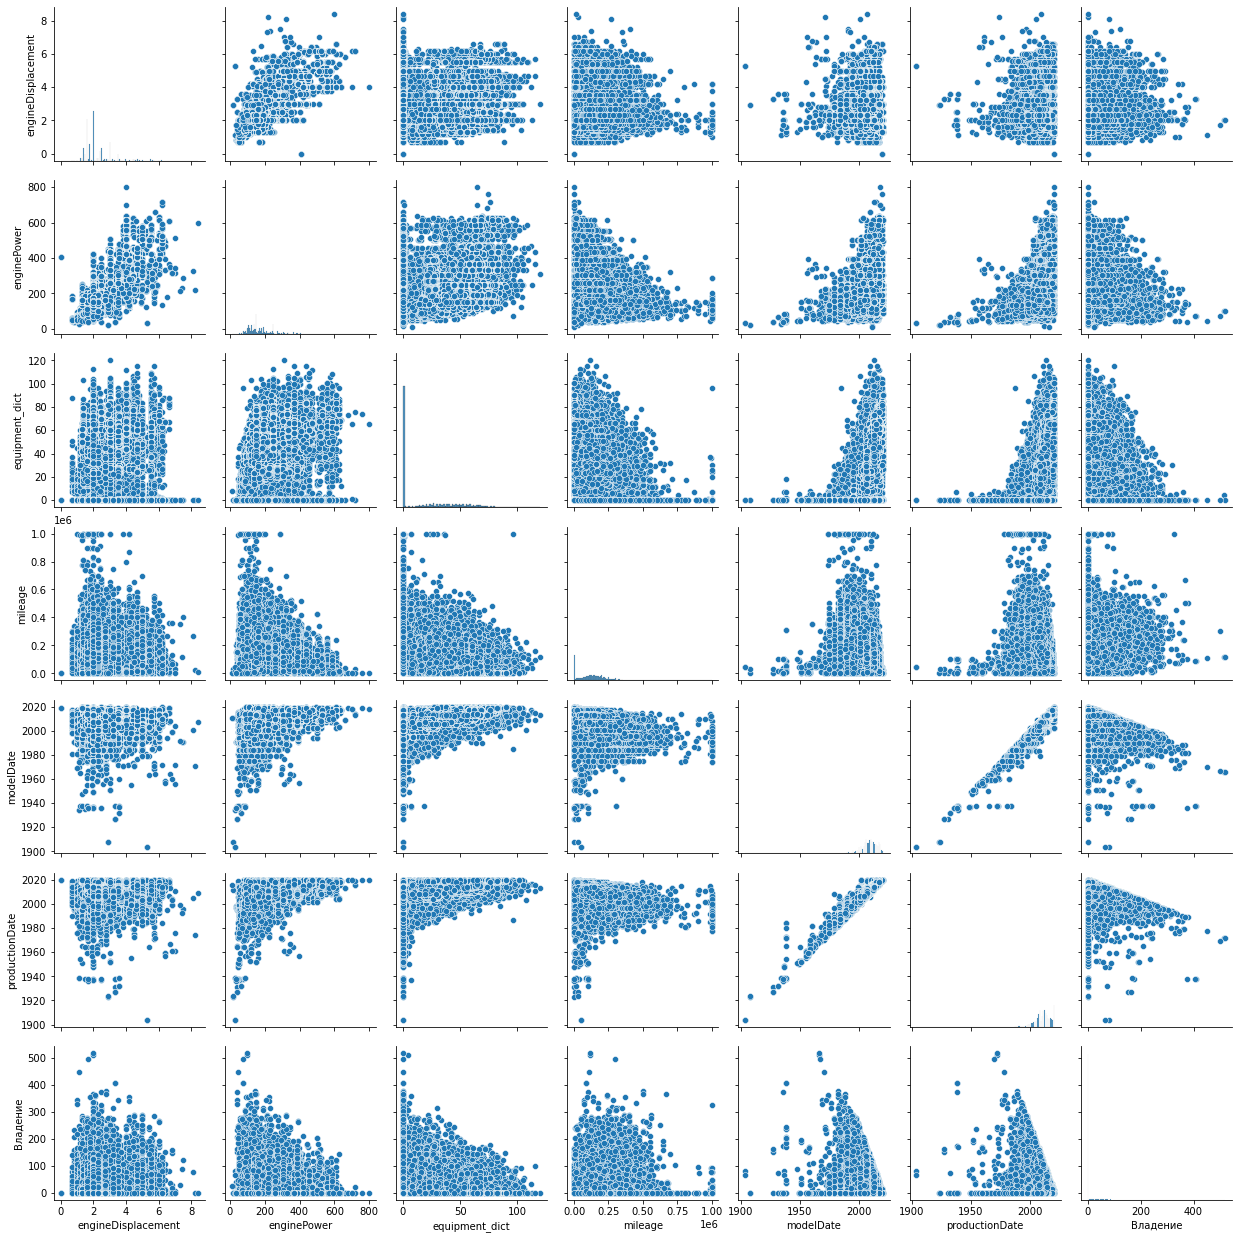

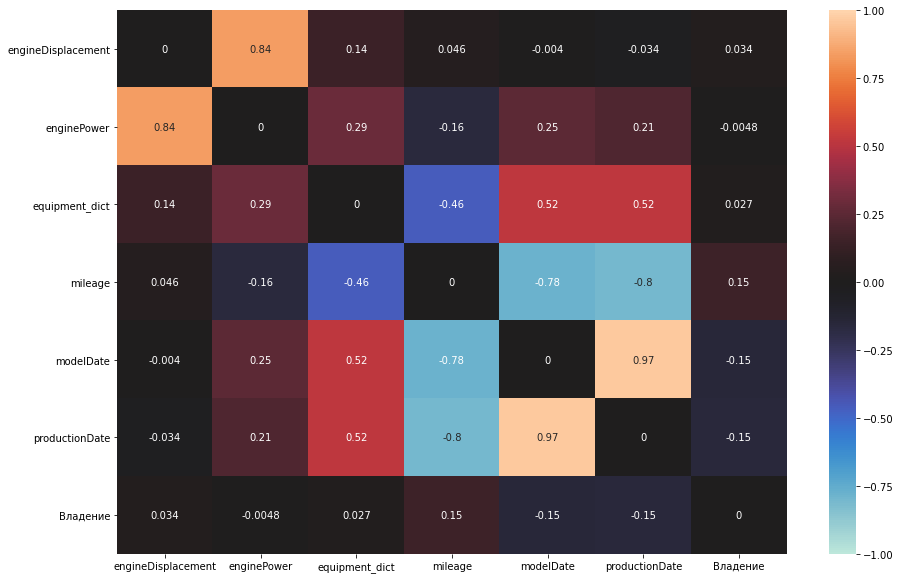

In [15]:
sns.pairplot(externdata_full[num_cols]);
corr_matrix = externdata_full[num_cols].corr(method='spearman')-np.eye(len(num_cols))
plt.figure(figsize = (15,10));
sns.heatmap(corr_matrix, annot = True,vmin=-1, vmax=1, center= 0);

Стоит отметить наличие заметных коррялици в нескольких парах признаков.   
    
Некоторые из корреляций обьясняются причинно-следственной связью признаков, например у таких как `engineDisplacement-enginePower`, `modelDate-productionDate`, `productionDate-mileage` - мощность двигателя зависит от его обьема, дата выпуска машины естественно связана с датой начала производства данной модели, а пробег в общем пропорционален возрасту автомобиля (т.е. связан с датой производства).    
    
Некоторые корреляции можно впролне обьяснить пользуясь здравым смыслом и жизненным опытом. Например 
`modelDate-enginePower`, `productionDate-enginePower` и `modelDate-equipment_dict` - в общем с течением времени мощность двигателей у новых моделей росла, также расла оснащенность автомобилей различными опциями.   
    
Некотрые корреляции не отражают какойлибо причинн-следственной связи и обьясняются зависимостью обех признаков от третьего. Напрмер в парах `equipment_dict-enginePower` и `equipment_dict-mileage` оба признака зависят от даты выпуска авто.   
    
Сделанные выводы о зависимостях помогут на этапе создания новых призгакв. Напрмер можно попробовать заменить один из сильно коррелированных `modelDate` и `productionDate` на разницу между ними, получив таким образом вполне осмысленный признак ***новизна модели***

Посмотрим на взаимную информацию, корреляции Спирмена количественных признаков и целевой переменной, а также на их pairplot-ы.

Wall time: 2min 45s


,engineDisplacement,enginePower,equipment_dict,mileage,modelDate,productionDate,Владение
MI,0.454021,0.935589,0.704977,0.474531,0.787019,0.666870,0.044839
Spearman corr,0.447695,0.660069,0.576510,-0.687421,0.794383,0.788078,-0.119163


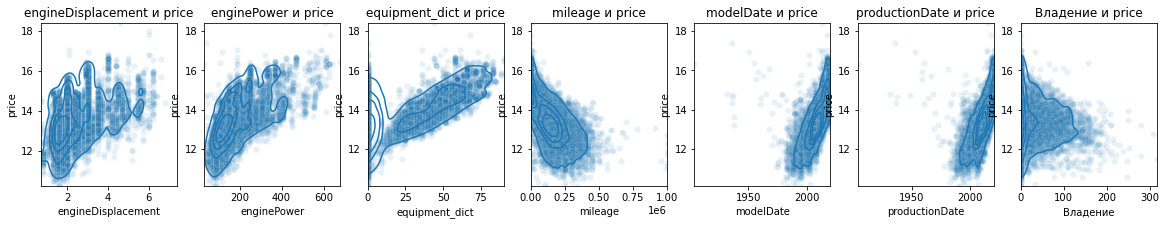

In [16]:
%%time
frac = 0.15
fig, ax = plt.subplots(1,len(num_cols), figsize=(20, 3))
for i,feat in enumerate(num_cols):
    notnamask = externdata_full[[feat,'price']].notna().all(axis=1)
    x = externdata_full[feat][notnamask].sample(frac=frac,random_state=42)
    y = externdata_full.price[notnamask].sample(frac=frac,random_state=42)
    ax[i].set_title(feat + ' и price')
    ax[i].set_xlabel(feat)
    ax[i].set_ylabel("price")
    ax[i].set(xlim=(x.min(), x.max()), ylim=(y.min(), y.max()))
    sns.kdeplot(x, y,ax=ax[i],n_levels=5) #, shade=True, shade_lowest=False
    sns.scatterplot(x, y,ax=ax[i],alpha=0.1)

sp_corr = [spearmanr(externdata_full[x],externdata_full.price,nan_policy='omit')[0] 
     for x in  externdata_full[list(num_cols)].dropna()]
without_na = externdata_full[list(num_cols)+['price']].dropna()
mi = mutual_info_regression(without_na[num_cols],without_na.price)

pd.DataFrame({'MI':mi,'Spearman corr':sp_corr},index = num_cols).T

Как видиим ... .... ..   
.... ..   
.... ..   
.... ..

### Детальное изучение
Теперь рассмотрим каждый признак отдельно, а именно 
- постоим график и box-plot признака на test и всем train, 
- график и box-plot признака на test и на данных train для марок встречающтхся в test.    
визуально сравним распределения.  
- затем построим зависимость целевой переменной от признака для трех самых популярных марок.

Получим три наиболее часто встречающиеся в data марки и модели:

Приступим к изучению признаков
### engineDisplacement
признак описывает обьем двигателя. 

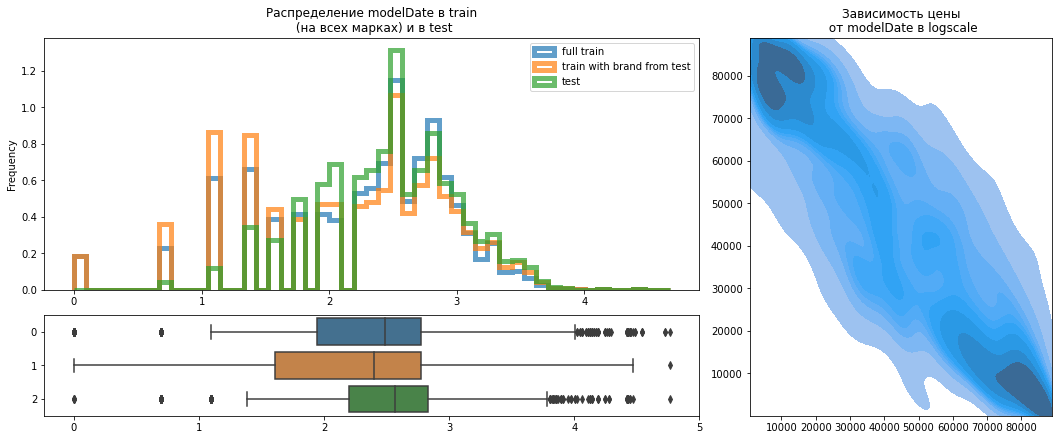

In [17]:
num_visualisation('modelDate',externdata_full,left_sloping=True)

In [18]:
externdata_full.nunique()

bodyType                  25
brand                     36
color                     16
engineDisplacement        68
enginePower              398
equipment_dict           114
fuelType                   5
mileage                24379
modelDate                 78
model_name              1104
numberOfDoors              5
productionDate            80
vehicleTransmission        4
vendor                     2
Владельцы                  3
Владение                 307
ПТС                        2
Привод                     3
Руль                       2
sample                     2
price                   8168
dtype: int64

In [40]:
# признаки для группировки изучаемого признака
feats_to_group = ['bodyType', 'brand', 'color', 'engineDisplacement',
       'equipment_dict', 'fuelType', 'mileage', 'modelDate', 'model_name',
       'numberOfDoors', 'productionDate', 'vehicleTransmission', 'vendor',
       'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'price']



for num_feat in num_cols[:1]:
    df = externdata_full[externdata_full['sample']==1].dropna(subset=[num_feat,'price'])
    for to_group in feats_to_group:
        groupped = df.groupby(to_group)
#         print(len(groupped[num_feat]))
        groupped_spcorr = groupped.apply(lambda x: spearmanr(x[[num_feat]],x.price))
        print(groupped_spcorr[:2])
        print('--------------------')

bodyType
внедорожник 3 дв.         (0.0609691302888336, 0.2518939913752516)
внедорожник 5 дв.    (0.09536948483551348, 1.7304249880362475e-65)
dtype: object
--------------------
brand
AUDI    (0.09091441013423225, 7.3975953914215625e-09)
BMW       (0.013515791060061892, 0.24636484602155076)
dtype: object
--------------------
color
бежевый    (0.3716223045366647, 2.2344810082233016e-61)
белый                         (0.5412186759228261, 0.0)
dtype: object
--------------------
engineDisplacement
0.0    (nan, nan)
0.7    (nan, nan)
0.8    (nan, nan)
1.0    (nan, nan)
1.1    (nan, nan)
1.2    (nan, nan)
1.3    (nan, nan)
1.4    (nan, nan)
1.5    (nan, nan)
1.6    (nan, nan)
1.7    (nan, nan)
1.8    (nan, nan)
1.9    (nan, nan)
2.0    (nan, nan)
dtype: object
--------------------
equipment_dict
0                     (0.48477544908510206, 0.0)
1    (0.6689351642096053, 9.953489492035783e-05)
dtype: object
--------------------
fuelType
бензин                     (0.40574119398212727, 0.0)
газ

In [38]:
groupped = df.groupby('bodyType')
groupped.apply(lambda x: spearmanr(x[[num_feat]],x.price))

bodyType
внедорожник 3 дв.                (0.0609691302888336, 0.2518939913752516)
внедорожник 5 дв.           (0.09536948483551348, 1.7304249880362475e-65)
внедорожник открытый           (0.5436040263184253, 0.024104723231370046)
кабриолет                     (0.4375888559476026, 3.006157297322464e-09)
компактвэн                  (-0.10717207935069376, 9.808730037698886e-07)
купе                          (0.4517281653994898, 5.117466838640632e-66)
купе-хардтоп                  (0.2777604287151949, 8.444622441585197e-05)
лимузин                         (0.23539595453459985, 0.6534278608778468)
лифтбек                        (0.220540194955516, 7.399384661084519e-39)
микровэн                        (-0.1024396745639356, 0.6338495045054995)
минивэн                     (-0.14837746886193148, 2.275513481510546e-13)
пикап двойная кабина        (0.34175919847982633, 3.1775384873630185e-17)
пикап одинарная кабина          (0.5090551266828431, 0.05261939837432001)
пикап полуторная кабина      

In [33]:
groupped_spcorr

price
9.680406     (nan, nan)
9.903538     (nan, nan)
9.952325     (nan, nan)
10.043293    (nan, nan)
10.126671    (nan, nan)
                ...    
17.877499    (nan, nan)
17.894531    (nan, nan)
17.996580    (nan, nan)
18.042344    (nan, nan)
18.410630    (nan, nan)
Length: 8137, dtype: object

In [77]:
externdata_full.apply(lambda x: x.dropna().value_counts().min(),axis=0)

bodyType                   4
brand                    295
color                     38
engineDisplacement         1
enginePower                1
equipment_dict             1
fuelType                  18
mileage                    1
modelDate                  1
model_name                 1
numberOfDoors              2
productionDate             1
vehicleTransmission    11023
vendor                 31805
Владельцы              27995
Владение                   1
ПТС                    15007
Привод                 11162
Руль                    3188
sample                 34686
price                      1
dtype: int64

In [131]:
column = 'engineDisplacement'
by_feat = 'modelDate'
df = externdata_full[externdata_full['sample']==1].dropna(subset=[column,'price'])

In [132]:
val_cnts = df.modelDate.value_counts().sort_index()
new_val_cnts = pd.Series(val_cnts.index,val_cnts.index)
from_year = val_cnts.index[0]

for year, cnt in zip(val_cnts.index,val_cnts):
    if val_cnts.loc[from_year:year].sum() >= 5: 
        new_val_cnts.loc[from_year:year] = year
        from_year = year+1
        
new_val_cnts.head()

1904    1927
1908    1927
1927    1927
1932    1936
1934    1936
dtype: int64

In [134]:
column = 'engineDisplacement'
by_feat = 'modelDate'
df = externdata_full[externdata_full['sample']==1].dropna(subset=[column,'price'])
df.modelDate = df.modelDate.map(new_val_cnts)
gr = df.groupby(by_feat)
gr_mi = gr.apply(lambda x: mutual_info_regression(x[[column]],x.price))
gr_spcorr = gr.apply(lambda x: spearmanr(x[[column]],x.price))
print('MI ',gr_mi.mean()[0],gr_mi.std())
print('Spearman',gr_spcorr.apply(lambda x: x[0]).mean(),gr_spcorr.apply(lambda x: x[0]).std())

Wall time: 0 ns
MI  0.4059321857080953 0.3312315992947072
Spearman 0.538644533771213 0.30204802951568815


In [135]:
gr_mi

modelDate
1927     [0.14444444444444482]
1936                       [0]
1937                       [0]
1938     [0.23703703703703738]
1950     [0.01666666666666683]
1955      [0.1491071428571431]
1958                       [0]
1959                       [0]
1961                       [0]
1964     [0.09722222222222254]
1967     [0.01666666666666683]
1968                       [0]
1970      [0.1166666666666667]
1971                       [0]
1972     [0.30730158730158763]
1974     [0.14123376623376682]
1975    [0.044483678910260505]
1976     [0.39494047619047645]
1977       [0.511435786435787]
1978     [0.23956349206349214]
1979     [0.10556857975253298]
1980     [0.21567231787820096]
1981     [0.04603469447219477]
1982     [0.06936621886367345]
1983     [0.26277354046037926]
1984      [0.3438369769905991]
1985      [0.5532723330283329]
1986      [0.4101911649049137]
1987      [0.3533018292578407]
1988     [0.14637100346249188]
1989      [0.3604321135704267]
1990      [0.5451154407776211

In [136]:
gr_spcorr

modelDate
1927         (0.6172133998483676, 0.1917443573414232)
1936        (-0.1043023302537743, 0.7743046543540669)
1937        (0.18136906252750293, 0.7703461020137523)
1938        (0.5316851282763626, 0.14068562052155587)
1950        (0.4472135954999579, 0.45018485575210093)
1955       (0.025031308716087948, 0.9530858971939759)
1958       (-0.6383106423916776, 0.06430829363590891)
1959          (0.5773502691896257, 0.308068009250357)
1961                        (0.3, 0.6238376647810728)
1964        (-0.4285714285714286, 0.3965014577259474)
1967       (0.46169025843831935, 0.43376615616902786)
1968        (0.3335621924974956, 0.46469707719905995)
1970        (0.8720815992723809, 0.05385421772754211)
1971         (0.1471875263602252, 0.7055126935938438)
1972        (0.828283210838796, 0.003074774223571227)
1974         (0.3533722901123976, 0.2864024043623504)
1975         (0.1754301882850764, 0.3368661475209005)
1976       (0.8058127442654065, 0.015743766603015043)
1977        (0.602

1    0
dtype: int64

In [122]:
# ind = val_cnts.index.to_list().index(1904)
# val_cnts.iloc[ind]

### категориальные

In [12]:
cat_cols

Index(['bodyType', 'color', 'fuelType', 'numberOfDoors', 'vehicleTransmission',
       'vendor', 'Владельцы', 'ПТС', 'Привод', 'model_name', 'brand'],
      dtype='object')

### бинарные

In [13]:
bin_cols

Index(['Руль'], dtype='object')

In [ ]:
cat_cols = data.columns[(num_uniq>2) & (num_uniq<28)].append(pd.Index(['model_name','brand'])) 

In [ ]:
num_cols = data.columns[num_uniq>=28].drop(time_col).drop(['model_name','brand','price'])

# ============================

%%html
<html>
<body>
<table>
        <tr> 
            <th>Name</th> 
            <th>Country</th> 
            <th>Age</th> 
        </tr> 
        <tr> 
            <td>Sid</td> 
            <td>India</td> 
            <td>22</td> 
        </tr>
        <tr> 
            <td>Dave</td> 
            <td>UK</td> 
            <td>28</td> 
        </tr>
</table>
</body>
</html>

In [ ]:
%lsmagic

In [140]:
externdata_full.columns

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'equipment_dict', 'fuelType', 'mileage', 'modelDate', 'model_name',
       'numberOfDoors', 'productionDate', 'vehicleTransmission', 'vendor',
       'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'sample', 'price'],
      dtype='object')

In [137]:
num_cols

Index(['engineDisplacement', 'enginePower', 'equipment_dict', 'mileage',
       'modelDate', 'productionDate', 'Владение'],
      dtype='object')

In [152]:
def features_price_scatterplot(df,stud_column,top_column, n_top):
    top = df[top_column].value_counts().index[:n_top]    
    fig, ax = plt.subplots(1,len(top), figsize=(20, 4))

    for i,cat_val in enumerate(top):
        tmp = df[df[top_column]==cat_val]
        x = tmp[stud_column]
        y = tmp.price
        ax[i].scatter(x = x, y = y, alpha=0.3)
        ax[i].set_title('для '+ top_column + ' ' + str(cat_val))
        ax[i].set_xlabel(stud_column)
        ax[i].set_ylabel("price")
#         ax[i].set_yscale( "log")
        xmarg = 0.1*(x.max() - max(x.min(),0))
        ax[i].set_xlim(left=max(x.min(),0)-xmarg,right = x.max()+xmarg)
#         ax[i].set_xmargin(0.2)
    plt.show(x.max()) 

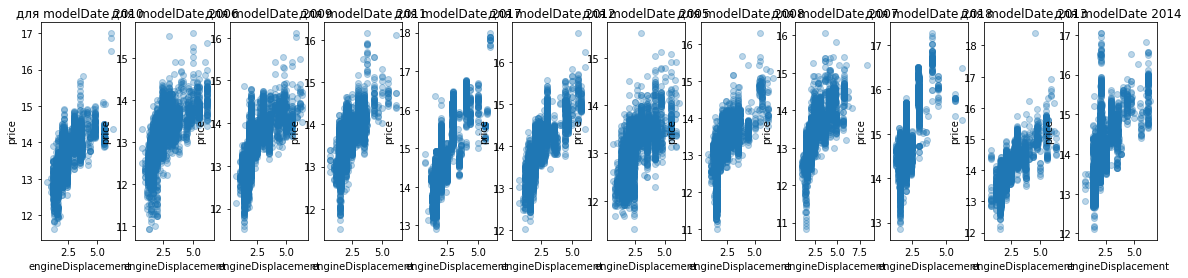

In [147]:
features_price_scatterplot(externdata_full,'engineDisplacement','modelDate',12)

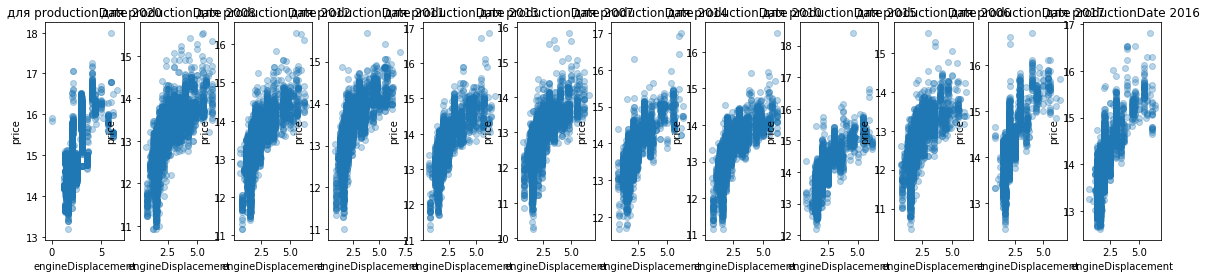

In [148]:
features_price_scatterplot(externdata_full,'engineDisplacement','productionDate',12)

In [144]:
# Поскольку в дальнейшем мы, вероятно, будем среди прочих использовать модели чувствительные к сильно ненормальному распределению признака, то применим к признакам преобразование (`log(x+1)` для скошенных вправо и `log(2022-x)` для сошеных влево).  
# Посмотрим на результат:

# to_log = ['engineDisplacement', 'enginePower', 'equipment_dict','mileage','Владение']
# to_minus_log = ['modelDate', 'productionDate']
# externdata_full[to_log] = np.log(externdata_full[to_log]+1)
# externdata_full[to_minus_log] = np.log(2022 - externdata_full[to_minus_log])

In [ ]:
# Картина улучшилась -  распределения либо стали близки к нормальному, либо скошенность 
# существенно уменьшилась. Далее будем работать спризнаком с учетом преобразования.

# nums_visualisation(np.log(externdata_full[[
#     'engineDisplacement', 'enginePower', 'equipment_dict','mileage','Владение']]+1))

# nums_visualisation(np.log(2022 - externdata_full[['modelDate', 'productionDate']]))

In [70]:
array = np.array([4,2,7,1])
rank = array.argsort().argsort()+1
rank

array([3, 2, 4, 1], dtype=int64)

In [71]:
from scipy.stats import rankdata
a = [4, 2, 7, 1]
rankdata(a)

array([3., 2., 4., 1.])

In [ ]:
x = 
y = externdata_full.price.

In [73]:
externdata_full.price.argsort().argsort()

0             0
1         23407
2         23406
3         23405
4         23404
          ...  
124058    65815
124059    68308
124060    94857
124061    96619
124062    94661
Name: price, Length: 124063, dtype: int64

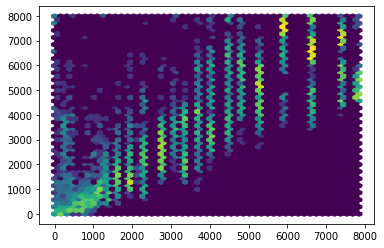

In [222]:
dff = externdata_full[externdata_full.brand == "MERCEDES"]
x = rankdata(dff.modelDate[dff.price.dropna().index] ) # ,method='ordinal'
y = rankdata(dff.price.dropna())
plt.hexbin(x,y, gridsize=50,bins='log')

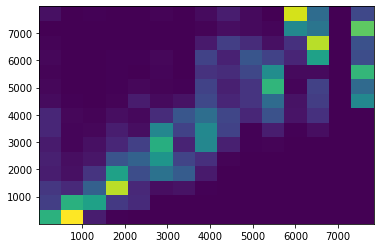

In [50]:
dff = externdata_full[externdata_full.brand == "MERCEDES"]
x = rankdata(dff.modelDate[dff.price.dropna().index] ) # ,method='ordinal'
y = rankdata(dff.price.dropna())
plt.hist2d(x,y,bins=15);

In [219]:
externdata_full.brand.unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI',
       'CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER', 'CITROEN', 'DAEWOO',
       'DODGE', 'FORD', 'GEELY', 'HYUNDAI', 'JAGUAR', 'JEEP', 'KIA',
       'MAZDA', 'MINI', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT', 'SUBARU',
       'SUZUKI', 'GREAT_WALL', 'LAND_ROVER', 'SSANG_YONG'], dtype=object)

In [98]:
test.productionDate.max()

2020

In [101]:
df_kaggle.productionDate.max()

2020

In [81]:
df_kaggle.astype(str).nunique()

bodyType                  103
brand                      12
color                      16
fuelType                    6
modelDate                  70
name                     2898
numberOfDoors               6
productionDate             72
vehicleConfiguration     1362
vehicleTransmission         5
engineDisplacement        412
enginePower               317
description             41877
mileage                  9787
Комплектация             2903
Привод                      4
Руль                        2
Состояние                   1
Владельцы                   4
ПТС                         3
Таможня                     1
Владение                  272
price                    6461
start_date              39528
hidden                      1
model                     554
dtype: int64

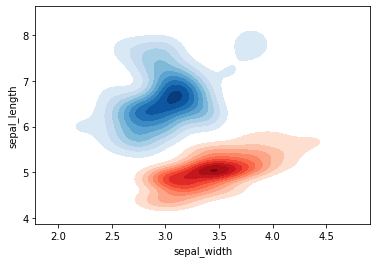

In [20]:
iris = sns.load_dataset("iris")
setosa = iris.loc[iris.species == "setosa"]
virginica = iris.loc[iris.species == "virginica"]
sns.kdeplot(setosa.sepal_width, setosa.sepal_length,
                  cmap="Reds", shade=True, shade_lowest=False)
sns.kdeplot(virginica.sepal_width, virginica.sepal_length,
                  cmap="Blues", shade=True, shade_lowest=False)

In [ ]:
feat = num_cols[1]
if 1:
    kkk = externdata_full[[feat,'price']].dropna()
    x = kkk[feat][:1000].values
    y = kkk.price[:1000].values
sns.kdeplot(x, y)#, shade=True, shade_lowest=False
# sns.scatterplot(x, y,alpha=0.1)
plt.show()

%%time
n = 0.01
num_rows = 2
num_columns = math.ceil(len(num_cols)/2)
fig, ax = plt.subplots(num_rows,num_columns, figsize=(20,8))
for i,feat in enumerate(num_cols):
    notnamask = externdata_full[[feat,'price']].notna().all(axis=1)
    x = externdata_full[feat][notnamask].sample(frac=n,random_state=42)
    y = externdata_full.price[notnamask].sample(frac=n,random_state=42)
    axx = i//num_columns
    axy = i%num_columns
    ax[axx,axy].set_title(feat + ' и price')
    ax[axx,axy].set_xlabel(feat)
    ax[axx,axy].set_ylabel("price")
    ax[axx,axy].set(xlim=(x.min(), x.max()), ylim=(y.min(), y.max()))
    sns.kdeplot(x, y,ax=ax[axx,axy],n_levels=5) #, shade=True, shade_lowest=False
    sns.scatterplot(x, y,ax=ax[axx,axy],alpha=0.3)
#     ax[i].contour([X, Y,] Z, [levels], **kwargs)

In [ ]:
%%time
frac = 0.15
fig, ax = plt.subplots(1,len(num_cols), figsize=(20, 3))
for i,feat in enumerate(num_cols):
    notnamask = externdata_full[[feat,'price']].notna().all(axis=1)
    x = externdata_full[feat][notnamask].sample(frac=frac,random_state=42)
    y = externdata_full.price[notnamask].sample(frac=frac,random_state=42)
    ax[i].set_title(feat + ' и price')
    ax[i].set_xlabel(feat)
    ax[i].set_ylabel("price")
    ax[i].set(xlim=(x.min(), x.max()), ylim=(y.min(), y.max()))
    sns.kdeplot(x, y,ax=ax[i],n_levels=5) #, shade=True, shade_lowest=False
    sns.scatterplot(x, y,ax=ax[i],alpha=0.1)

In [ ]:
# sns.pairplot(externdata_full[list(num_cols) + ['price']],
#              x_vars=list(num_cols) ,
#              y_vars=['price'],
#              aspect=0.7)